<!-- <h1 style="background:green;">Your Name</h1> -->


# Demand Forecasting Project
1.	Download electricityLoadData.csv from the shared box and upload to your own google drive 
2.	Instructions for coding (What you need to code):
    - Load data and preprocess data using the predefined functions.
    - Go to `build_model` section and define your own network.
    - Choose your parameters to set up the training routine.
    - Plot your result by using the `Analyze Result` section.
    - Print your notebook by clicking File > Save > PDF to upload your work.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
import time

plt.style.use('fivethirtyeight')
FILE_PATH = "electricityLoadData - Q3.csv"
WINDOW = 48

In [9]:
### Data Loading and Preprocessing Functions ###
def read_data(file_path):
    data = pd.read_csv(file_path, header=1, error_bad_lines=False)
    data.drop(data.columns[[2]], axis=1, inplace=True) # drop year
    return data
  
def normalize_data(dataset): 
    # minmax normalize 
    values = dataset.values
    minima_demand = np.amin(values[:, -1])
    maxima_demand = np.amax(values[:, -1])
    scaling_parameter_demand = maxima_demand - minima_demand
    for i in range(values.shape[1]):
        values[:, i] = (values[:, i]-np.amin(values[:, i]))/(np.amax(values[:, i])-np.amin(values[:, i]))
    return minima_demand, maxima_demand, scaling_parameter_demand, pd.DataFrame(values)

def prepare_data(dataset, window_size):
    amount_of_features = len(dataset.columns)
    data = dataset.values
    sequence_length = window_size + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    windowed_mat = np.array(result)

    train_split = int(round(0.8 * windowed_mat.shape[0]))
    x_train = windowed_mat[:train_split, :-1]
    y_train = windowed_mat[:train_split, -1][:,-1]
    x_test = windowed_mat[train_split:, :-1]
    y_test = windowed_mat[train_split:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
    return x_train, y_train, x_test, y_test


In [10]:
### Load and Preprocess Data ###
dataset = read_data(FILE_PATH)
min_demand, max_demand, demand_scaling_param, dataset = normalize_data(dataset)
X_train, y_train, X_test, y_test = prepare_data(dataset[::-1], WINDOW)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (56062, 48, 5)
y_train shape: (56062,)
X_test shape: (14016, 48, 5)
y_test shape: (14016,)


C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_5836\811291537.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_path, header=1, error_bad_lines=False)


In [11]:
### Model Definition and Training ###
model = Sequential([
    LSTM(256, activation='relu', input_shape=(48,5)),
    Dense(128),
    Dense(64),
    Dense(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

print("Model Summary:")
model.summary()

model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=15,
    validation_split=0.2,
    verbose=2)

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               268288    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 311,553
Trainable params: 311,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
351/351 - 42s - loss: 0.

In [12]:
def denormalize_data(data, scaling_parameter, minima):
    """Denormalizes the input data."""
    return (data * scaling_parameter) + minima

def calculate_mape(y_true, y_pred):
    """Calculates the mean absolute percentage error."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_forecast(actual, predicted, time_window=24):
    """Plots the actual vs predicted forecast."""
    plt.plot(actual[:time_window], label='Actual', color='blue')
    plt.plot(predicted[:time_window], label='Predicted', color='red')
    plt.xlabel('Time Sequence')
    plt.ylabel('Load (MW)')
    plt.title(f'Actual vs Predicted Results in the Next {time_window * 1800} Seconds')
    plt.legend()
    plt.show()

438/438 [==============================] - 11s 24ms/step
Test MAPE: 27.731
Test MAE: 561.951


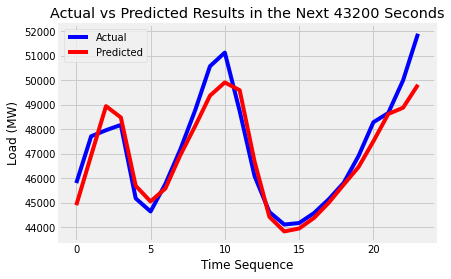

In [13]:
# Get the predicted and actual data
predicted = denormalize_data(model.predict(X_test), demand_scaling_param, min_demand)
actual = denormalize_data(y_test, demand_scaling_param, min_demand)

# Calculate and print the mean absolute percentage error and mean absolute error
mape = calculate_mape(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print(f'Test MAPE: {mape:.3f}')
print(f'Test MAE: {mae:.3f}')

#Plot the forecast
plot_forecast(actual, predicted)